Can we create an encoder-decoder model for character data that acts as an embedding layer?

If we could, our models could just predict the embedding, which may then be decoded to generate the word. For example, our decoder could just predict a 100D vector for each timestamp, which represents the word.

Don't reset our GRU state as we read in characters?

Plan:

* Load Glove Embeddings.
* Load text.
* Tokenize text > words.
* For each word - build an encoder:
    * Clean characters.
    * Add control characters to start and end > convert to numbers.
    * Batch by length of word - 0-5,5-10,10-20, 20+ (or cap /arbitrarily break at 20?)
    * Set as GRU sequences;
    * Set Y as embedding for word;
    * Use MSE loss and train.
* Also build a decoder:
    * Input initial state = embedding. Token = start sequence.
    * Train with input sequence char + output sequence char shifted by one.

In [4]:
import pickle
import os

PIK = "claim_and_title.data"

if not os.path.isfile(PIK):
    # Download file
    !wget https://benhoyle.github.io/notebooks/title_generation/claim_and_title.data

with open(PIK, "rb") as f:
    print("Loading data")
    data = pickle.load(f)
    print("{0} samples loaded".format(len(data)))

Loading data
30000 samples loaded


In [3]:
from nltk import word_tokenize

In [7]:
# Tokenize words
data_as_words = [word_tokenize(d[0].lower().strip()) for d in data]

In [9]:
data_as_words[0][0:10]

['1.',
 'a',
 'method',
 'for',
 'managing',
 'a',
 'backup',
 'service',
 'gateway',
 '(']

In [14]:
# Filter out non-words
data_as_words = [word for claim in data_as_words for word in claim if word.isalpha()]

In [16]:
print("We have {} words.".format(len(data_as_words)))

We have 6268278 words.


In [18]:
data_as_words[0:10]

['a',
 'method',
 'for',
 'managing',
 'a',
 'backup',
 'service',
 'gateway',
 'sgw',
 'associated']

In [24]:
import numpy as np

# Load Glove Embeddings
print("Loading GloVe 100d embeddings from file")
GLOVE_DIR = "glove/"

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), 'rb')
for line in f:
    values = line.split()
    # Tweaked to decode the binary text values
    word = values[0].decode('utf-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Loading GloVe 100d embeddings from file


In [32]:
# Setup character vocab 
import string
char_vocab = ["_PAD_", "_SOW_", "_EOW_"] + list(string.ascii_lowercase)
print("There are {} character tokens".format(len(char_vocab)))

There are 29 character tokens


In [33]:
# Convert words to ints
# Build dictionaries
reverse_dict = {i: c for i, c in enumerate(char_vocab)}
forward_dict = {v: k for k, v in reverse_dict.items()}

In [34]:
# Generate embedding - character list pairs
dataset = []
for word in data_as_words:
    embedding = embeddings_index.get(word, None)
    if embedding is not None:
        try:
            word_as_int = [forward_dict["_SOW_"]] + [forward_dict[c] for c in word] + [forward_dict["_EOW_"]]
            dataset.append((embedding, word_as_int))
        except KeyError:
            continue
        

In [35]:
print("There are now {0} entries in the dataset".format(len(dataset)))
dataset[1]

There are now 6251296 entries in the dataset


(array([-4.1796e-01,  5.3241e-01, -3.3693e-01,  6.9262e-01,  6.8686e-02,
        -8.7566e-02,  2.7663e-01, -7.1203e-02, -3.3530e-01,  3.3365e-01,
        -5.2407e-01, -5.3341e-01,  4.0460e-02, -1.6659e-01,  4.5481e-01,
        -3.4785e-01,  2.4926e-01,  2.2734e-02,  4.2120e-01,  6.2452e-03,
        -1.3359e-01, -5.1309e-01,  2.1382e-01, -2.4943e-01, -3.6553e-01,
        -1.0690e-02,  2.5961e-01, -2.9090e-01, -7.6780e-01,  3.7387e-02,
        -4.6895e-01,  8.9278e-01, -5.3101e-01, -3.8841e-01,  3.5913e-01,
        -4.7930e-01, -3.3601e-01, -2.0371e-01,  3.9182e-01, -9.5175e-01,
        -6.2779e-01,  1.7753e-01, -3.5282e-02, -1.2463e-01, -8.4179e-01,
        -3.4632e-01, -1.9631e-01, -8.4428e-01, -5.4253e-01, -1.9322e-01,
         2.5287e-01, -1.2990e-02, -1.4000e-03,  1.4574e+00, -7.6291e-01,
        -1.5731e+00, -2.3982e-01,  2.2269e-01,  8.7785e-01, -3.4078e-02,
        -3.6702e-02, -3.1008e-01,  8.0324e-01,  6.1032e-01,  1.3546e+00,
        -1.4522e-01, -1.9501e-01, -6.8654e-01, -9.6

In [ ]:
# char_emb_dim = 8
#decoder_embedding = Embedding(input_dim = num_decoder_tokens, output_dim=char_emb_dim)(decoder_inputs)

To cut a long story short - we need to use one-hot encodings of our character data for our decoder inputs and outputs. As there are around 6m samples, we need to break up our training data into batches (we have matrices of 6m, 20, 29). As we need to break our training data into batches, we can maybe create batches of different sizes.

In [103]:
from keras.layers import GRU, Input, Dense, Embedding
from keras.models import Model

embedding_dim = 100
num_decoder_tokens = len(char_vocab)
# Limit word length to 20
decoder_seq_length = 20

encoded_state = Input(shape=(embedding_dim,), name="EncodedState")
decoder_inputs = Input(shape=(None, num_decoder_tokens), name="DecoderInputs")
decoder_gru = GRU(embedding_dim, return_sequences=True, name="Decoder")
decoder_outputs = decoder_gru(decoder_inputs, initial_state=encoded_state)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name="VocabProjection")
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoded_state, decoder_inputs], decoder_outputs)

model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc']
        )

In [86]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(model, show_shapes=True).create_png(prog='dot'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [92]:
def inputs_to_one_hot(input_seqs, decoder_seq_length, num_decoder_tokens):
    """ Convert a sequence of integers to normal and shifted one-hot representations a one element shifted
        sequence of one-hot vectors."""
    length = len(input_seqs)
    one_hot_in = np.zeros(
            (length, decoder_seq_length, num_decoder_tokens)
            )
    one_hot_out = np.zeros(
            (length, decoder_seq_length, num_decoder_tokens)
            )
    for i, sequence in enumerate(input_seqs):
        for timestamp, word_int in enumerate(sequence):
            one_hot_in[i, timestamp, word_int] = 1
            if timestamp > 0:
                # Shift decoder target get so it is one ahead
                one_hot_out[i, timestamp-1, word_int] = 1
    return one_hot_in, one_hot_out

With embedding for characters.
```
from keras.layers import GRU, Input, Dense, Embedding
from keras.models import Model

embedding_dim = 100
num_decoder_tokens = len(char_vocab)
# Limit word length to 20
decoder_seq_length = 20
# Character embedding dimension
char_emb_dim = 8

encoded_state = Input(shape=(embedding_dim,), name="EncodedState")
decoder_inputs = Input(shape=(None, ), name="DecoderInputs")
decoder_embedding = Embedding(input_dim = num_decoder_tokens, output_dim=char_emb_dim)(decoder_inputs)
decoder_gru = GRU(embedding_dim, return_sequences=True, name="Decoder")
decoder_outputs = decoder_gru(decoder_embedding, initial_state=encoded_state)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name="VocabProjection")
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoded_state, decoder_inputs], decoder_outputs)
```


Our longest sequence is 24 tokens long.


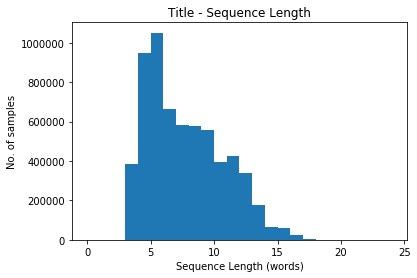

In [45]:
import matplotlib.pyplot as plt

%matplotlib inline

# Let's have a look at our word length distribution
Y_length = [len(y) for e, y in dataset]
max_y_length = max(Y_length)
print("Our longest sequence is {0} tokens long.".format(max_y_length))

bins = np.linspace(0, max_y_length, 25)
plt.hist(Y_length, bins)
plt.title('Title - Sequence Length')
plt.ylabel('No. of samples')
plt.xlabel('Sequence Length (words)')
plt.show()

In [94]:
# Shall we try using the keras to_categorial method and then shift this as before
# To test our model works we'll just select the first 500k sampes
decoder_in_seqs = [y for e,y in dataset[0:50000]]
decoder_in_seqs, decoder_out_seqs = inputs_to_one_hot(decoder_in_seqs, decoder_seq_length, num_decoder_tokens)

In [95]:
print(decoder_in_seqs.shape, decoder_out_seqs.shape)

(50000, 20, 29) (50000, 20, 29)


In [ ]:
# Here we split our data into batches of different lengths - we can then compute our shifted output vector

In [58]:
# Note - with ints we can use just array slicing to shift
# Could we build one hot conversion into model as a layer? Would save having to convert all the data first
# decoder_out_seqs = np.zeros(decoder_in_seqs.shape, dtype='int32')
# decoder_out_seqs[:, 0:19] = decoder_in_seqs[:, 1:20]
# decoder_out_seqs.shape

In [96]:
encoded_states = np.array([e for e, y in dataset[0:50000]])

In [97]:
encoded_states.shape

(50000, 100)

In [105]:
callback = model.fit([encoded_states, decoder_in_seqs], decoder_out_seqs, validation_split=0.1, batch_size=64, epochs=100)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 24s 523us/step - loss: 0.3078 - acc: 0.2275 - val_loss: 0.2953 - val_acc: 0.2339
Epoch 2/100
45000/45000 [==============================] - 23s 519us/step - loss: 0.2238 - acc: 0.2523 - val_loss: 0.2541 - val_acc: 0.2459
Epoch 3/100
45000/45000 [==============================] - 24s 524us/step - loss: 0.1766 - acc: 0.2657 - val_loss: 0.2285 - val_acc: 0.2539
Epoch 4/100
45000/45000 [==============================] - 23s 522us/step - loss: 0.1460 - acc: 0.2744 - val_loss: 0.2124 - val_acc: 0.2604
Epoch 5/100
45000/45000 [==============================] - 23s 521us/step - loss: 0.1247 - acc: 0.2808 - val_loss: 0.2050 - val_acc: 0.2630
Epoch 6/100
45000/45000 [==============================] - 24s 523us/step - loss: 0.1091 - acc: 0.2850 - val_loss: 0.1967 - val_acc: 0.2672
Epoch 7/100
45000/45000 [==============================] - 23s 522us/step - loss: 0.0972 - acc: 0.2882 - val_lo

KeyboardInterrupt: 

### Comments on Initial Training

This seems to reach a local minima within 10 epochs.

Now we need to code up our loop through the 6million examples in sets of 100k. We'll need to initially create different test and training datasets that we keep separate. Can we use / edit our existing models?

What does training do? It captures information about two things:

* The data values themselves (e.g. character sequences per word); and
* The distribution of the words in the dataset.



In [107]:
input_data = [e for e, y in dataset]
output_data = [y for e, y in dataset]

In [188]:
from char_gen import CharS2S

We want to build an abstract class that has the encoder and decoder systems as separate replaceable modules. E.g. process_encoder_input, process_decoder_input.

In [189]:
char_s2s = CharS2S(
    encoder_states=input_data,
    decoder_seqs=output_data,
    decoder_seq_length=20,
    latent_dim=100,
    weights_file="charstate2seq.hdf5",
    training_set_size=50000,  # Due to memory we need to train in sets
    batch_size=128
)

Building model
Loaded weights
Generating training and test data


Training for epoch 0
Training on batch 0 to 50000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 22s 439us/step - loss: 0.6185 - acc: 0.1368 - val_loss: 0.4443 - val_acc: 0.1886
Training on batch 50000 to 100000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 380us/step - loss: 0.3761 - acc: 0.2077 - val_loss: 0.3261 - val_acc: 0.2227
Training on batch 100000 to 150000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 374us/step - loss: 0.2954 - acc: 0.2294 - val_loss: 0.2736 - val_acc: 0.2381
Training on batch 150000 to 200000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 374us/step - loss: 0.2524 - acc: 0.2438 - val_loss: 0.2303 - val_acc: 0.2492
Training on batch 200000 to 250000 of 5001036
Trai

Training on batch 1750000 to 1800000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 375us/step - loss: 0.0844 - acc: 0.2892 - val_loss: 0.0857 - val_acc: 0.2902
Training on batch 1800000 to 1850000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 373us/step - loss: 0.0806 - acc: 0.2912 - val_loss: 0.0788 - val_acc: 0.2912
Training on batch 1850000 to 1900000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 376us/step - loss: 0.0802 - acc: 0.2903 - val_loss: 0.0801 - val_acc: 0.2916
Training on batch 1900000 to 1950000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 20s 392us/step - loss: 0.0796 - acc: 0.2908 - val_loss: 0.0789 - val_acc: 0.2917
Training on batch 1950000 to 2000000 of 5001036
Train on

50000/50000 [==============================] - 19s 387us/step - loss: 0.0664 - acc: 0.2951 - val_loss: 0.0704 - val_acc: 0.2948
Training on batch 3500000 to 3550000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 384us/step - loss: 0.0660 - acc: 0.2944 - val_loss: 0.0688 - val_acc: 0.2928
Training on batch 3550000 to 3600000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 385us/step - loss: 0.0662 - acc: 0.2941 - val_loss: 0.0657 - val_acc: 0.2964
Training on batch 3600000 to 3650000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 385us/step - loss: 0.0665 - acc: 0.2930 - val_loss: 0.0693 - val_acc: 0.2920
Training on batch 3650000 to 3700000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 20s 408us

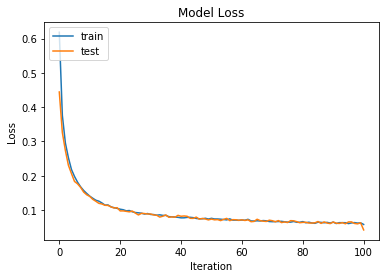

In [121]:
char_s2s.train()

```
Training on batch 4950000 to 5000000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 20s 392us/step - loss: 0.0625 - acc: 0.2959 - val_loss: 0.0627 - val_acc: 0.2938
```

Now we need to look at what this is generating!

It is noted that the accuracy is only 30% - it would be interested to see how this is manifesting.

In [190]:
char_s2s.print()

Training Model:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DecoderInputs (InputLayer)      (None, None, 29)     0                                            
__________________________________________________________________________________________________
EncodedState (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
Decoder (GRU)                   [(None, None, 100),  39000       DecoderInputs[0][0]              
                                                                 EncodedState[0][0]               
__________________________________________________________________________________________________
VocabProjection (Dense)         (None, None, 29)     2929        Decoder[0][0]              

Training for epoch 0
Training on batch 0 to 50000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 387us/step - loss: 0.0599 - acc: 0.2965 - val_loss: 0.0595 - val_acc: 0.2963
Training on batch 50000 to 100000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 386us/step - loss: 0.0610 - acc: 0.2957 - val_loss: 0.0595 - val_acc: 0.2956
Training on batch 100000 to 150000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 384us/step - loss: 0.0630 - acc: 0.2945 - val_loss: 0.0650 - val_acc: 0.2967
Training on batch 150000 to 200000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 386us/step - loss: 0.0632 - acc: 0.2965 - val_loss: 0.0595 - val_acc: 0.2960
Training on batch 200000 to 250000 of 5001036
Trai

Training on batch 1750000 to 1800000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 383us/step - loss: 0.0588 - acc: 0.2964 - val_loss: 0.0599 - val_acc: 0.2971
Training on batch 1800000 to 1850000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 386us/step - loss: 0.0577 - acc: 0.2974 - val_loss: 0.0571 - val_acc: 0.2971
Training on batch 1850000 to 1900000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 387us/step - loss: 0.0577 - acc: 0.2963 - val_loss: 0.0571 - val_acc: 0.2984
Training on batch 1900000 to 1950000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 387us/step - loss: 0.0554 - acc: 0.2973 - val_loss: 0.0561 - val_acc: 0.2978
Training on batch 1950000 to 2000000 of 5001036
Train on

50000/50000 [==============================] - 19s 377us/step - loss: 0.0546 - acc: 0.2983 - val_loss: 0.0582 - val_acc: 0.2980
Training on batch 3500000 to 3550000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 387us/step - loss: 0.0539 - acc: 0.2977 - val_loss: 0.0576 - val_acc: 0.2960
Training on batch 3550000 to 3600000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 388us/step - loss: 0.0551 - acc: 0.2970 - val_loss: 0.0555 - val_acc: 0.2992
Training on batch 3600000 to 3650000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 387us/step - loss: 0.0548 - acc: 0.2960 - val_loss: 0.0589 - val_acc: 0.2950
Training on batch 3650000 to 3700000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 386us

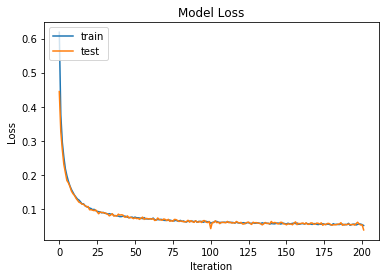

In [123]:
char_s2s.train()

In [191]:
char_s2s.example_output(100)

------------------------------------------
Predicted word is: a s 
Actual word is: a s  
---
Predicted word is: t h e 
Actual word is: t h e  
---
Predicted word is: p r o c e s s i n g 
Actual word is: p r o c e s s i n g  
---
Predicted word is: m a n a g e m e n t 
Actual word is: m a n a g e m e n t  
---
Predicted word is: t h e 
Actual word is: t h e  
---
Predicted word is: o t h e r 
Actual word is: o t h e r  
---
Predicted word is: a n d 
Actual word is: a n d  
---
Predicted word is: m e n u r e t 
Actual word is: c o l l a t e r a l  
---
Predicted word is: o n 
Actual word is: o n  
---
Predicted word is: i n 
Actual word is: i n  
---
Predicted word is: m e m b e r s 
Actual word is: m e m b e r s  
---
Predicted word is: p r o t e c t i o n 
Actual word is: p r o t e c t i o n  
---
Predicted word is: r e c l i v e 
Actual word is: s u p p o r t i n g  
---
Predicted word is: a n d 
Actual word is: a n d  
---
Predicted word is: p e r f o r m 
Actual word is: p e r f o r

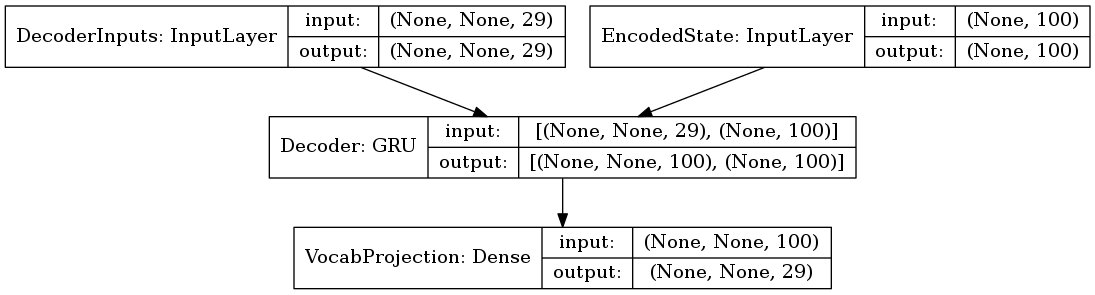

In [192]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(self.model, show_shapes=True).create_png(prog='dot'))

Ideas for improving performan

In [ ]:
# 

class CharS2S_ext(CharS2S):
    def _build_model(self):
        """ Build the model. """
        print("Building model")
        encoded_state = Input(shape=(self.latent_dim,), name="EncodedState")
        decoder_inputs = Input(shape=(None, self.num_decoder_tokens), name="DecoderInputs")
        decoder_gru = GRU(self.latent_dim, return_sequences=True, return_state=True, name="Decoder")
        decoder_outputs, decoder_state = decoder_gru(decoder_inputs, initial_state=encoded_state)
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name="VocabProjection")
        decoder_outputs = decoder_dense(decoder_outputs)
        self.model = Model([encoded_state, decoder_inputs], decoder_outputs)

        # We also need an inference model
        self.infdec = Model(inputs=[encoded_state, decoder_inputs], outputs=[decoder_outputs, decoder_state])

        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc']
        )